In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

# Dataset subclass

In [3]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False,
                 subset=None):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
            - subset: the number of examples from each class to include in dataset
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            
            if subset is not None:
                assert type(subset) is int, 'argument subset must be of type int'
                filenames = filenames[:subset]
            
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

# Create MNIST dataset

In [4]:
# Create the MNIST dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]
trainset = MNIST(
    root='mnist_png/training',
    preload=True, 
    transform=transforms.ToTensor(),
    subset = 1000
)

# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# load the testset
testset = MNIST(
    root='mnist_png/testing',
    preload=True, 
    transform=transforms.ToTensor(),
    subset = 200
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [5]:
print(len(trainset))
print(len(testset))

10000
2000


### Visualize the dataset

tensor(1) tensor(9) tensor(5) tensor(7) tensor(7) tensor(3) tensor(3) tensor(9) tensor(9) tensor(9) tensor(9) tensor(5) tensor(4) tensor(6) tensor(4) tensor(2)


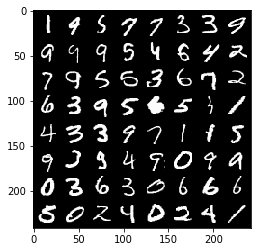

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

In [7]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

cpu


# Define a model architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Get gradient of inputs

# try with a single input
example, example_label = trainset[15] # Get one training example to work with
example = example.unsqueeze(0) # Unsqueeze to add extra dimension (nn.Module only accepts batches not single examples)
# example = example.to(device)
print('Input size: {}'.format(example.size()))


# try with a batch of inputs, instead of just one input
# dataiter = iter(trainset_loader)
# example, example_label = dataiter.next()
# print('Input size: {}'.format(example.size()))


# IMPORTANT: MAKE SURE YOU TURN ON REQUIRES_GRAD BEFORE COMPUTING OUTPUT
print('example.requires_grad = {}'.format(example.requires_grad))
example.requires_grad_(True) # tell PyTorch that we want to keep track of gradients w.r.t. inputs
print('example.requires_grad = {}'.format(example.requires_grad))

output = my_model(example)

my_model.zero_grad() # zero out all gradients in model so they don't accumulate
dout = torch.ones_like(output, dtype=torch.float)

grad = torch.autograd.grad(outputs=output, inputs=example, grad_outputs=dout)

print('Shape of gradient of scores w.r.t. input: \n{}'.format(grad[0].size()))
# print('Gradient of scores w.r.t. input: \n{}'.format(grad[0]))



# ------------------------------------------------------------------------------
# We want derivative of scores (NOT loss) with respect to input
# Use torch.autograd.grad() function to obtain gradients of scores w.r.t. input
# argument 'outputs': the vector (or scalar) w/ respect to which you want to take derivatives
# argument 'inputs' : the vector (or scalar) of variables w.r.t. which you're differentiating
# arugment 'grad_outputs': a vector (or scalar) of derivatives of the final output layer w.r.r. 
# the layer you specify with the 'outputs' argument 
# So what's going on here, is that you basically choose an arbitrary end point in the graph, 
# and manually feeding in the derivative of that layer w.r.t. the final output of the network
# ------------------------------------------------------------------------------


# Most important stuff I've done so far is in the following two code blocks

In [ ]:
def FGSM(input_img, input_label, model, target, epsilon, num_iters=1000):
    '''
    Produce an adversarial image utilizing the Fast Gradient Sign method
    (more accurately, the Iterative Gradient Sign method), as described 
    by Carlini and Wagner in https://arxiv.org/abs/1608.04644
    Arguments:
        - input image: torch tensor
        - input label: class label of input image
        - model: model used to make predictions
        - target class: class to trick the model into predicting
        - epsilon: number of 
        - num_iters: how many times to add a perturbation to image
    '''
    #  NOTE: you can probably do this in batches. <--------------- do this later
    
    natural = input_img.clone().unsqueeze(0)
    input_img = input_img.clone().unsqueeze(0)
    input_img.requires_grad_(True)
    
    perturbation = torch.zeros_like(input_img)
    fooled = False
    iteration = 0

    while fooled is False and iteration < num_iters:
        
        output = model(input_img)
        model.zero_grad() # zero out all gradients in model so they don't accumulate
        dout = torch.zeros_like(output, dtype=torch.float)
        dout[0][target] += 1.  # only compute gradient w.r.t. target class
        grad = torch.autograd.grad(outputs=output, inputs=input_img, grad_outputs=dout)[0]
        
        with torch.no_grad():
#             perturbation.add_(epsilon * torch.sign(grad))
#             input_img.add_(epsilon * torch.sign(grad))
            perturbation.add_(epsilon * grad)
            input_img.add_(epsilon * grad)
            
            prediction = model(input_img)
            prediction = prediction.max(1, keepdim=True)[1][0,0].item()

            if prediction == target:
                fooled = True
            iteration += 1
        
    print('Number of iterations required: {}'.format(iteration))
    perturbation = perturbation.detach()
    advsersary = input_img.detach()
    
    return (natural, perturbation, advsersary)

In [ ]:
# i = np.random.randint(len(testset))
i = 401
target = 2
eps = 1e-3
num_iters = 15000

t, t_label = testset[i] # Get one training example to work with

print('True label: {}'.format(t_label))
# print('Target class: {}'.format(target))
print('\n\n')

# natural, pert, adv = FGSM(t, t_label, model, target, eps, num_iters)

# nat_pred = model(natural).max(1, keepdim=True)[1][0,0].item()
# adv_pred = model(adv).max(1, keepdim=True)[1][0,0].item()
# print('Natural image prediction: {}'.format(nat_pred))
# print('Adversarial image prediction: {}'.format(adv_pred))
# compare_plots(natural, pert, adv)

import time
begin = time.time()

for j in range(10):
    if j == t_label:
        continue
    natural, pert, adv = FGSM(t, t_label, model, j, eps, num_iters)

    nat_pred = model(natural).max(1, keepdim=True)[1][0,0].item()
    adv_pred = model(adv).max(1, keepdim=True)[1][0,0].item()
    print('Natural image prediction: {}'.format(nat_pred))
    print('Adversarial image prediction: {}'.format(adv_pred))
    compare_plots(natural, pert, adv)
    print('\n\n')
    
print('Took {} seconds'.format(time.time() - begin))

In [ ]:
def compare_plots(natural, perturbation, adversary):
    plt.subplot(1,3,1)
    plt.imshow(natural.numpy()[0,0], cmap='binary')
    plt.title('Natural Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,3,2)
    plt.imshow(perturbation.numpy()[0,0], cmap='binary')
    plt.title('Perturbation')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,3,3)
    plt.imshow(adversary.numpy()[0,0], cmap='binary')
    plt.title('Adversarial Image')
    plt.xticks([])
    plt.yticks([])

    plt.show()


In [ ]:
def FGSM_modified(input_img, input_label, model, target, epsilon, num_iters=1000):
    '''
    Same as above except you iterate over all classes when computing gradients, 
    instead of just the target class
    '''
    
    #  NOTE: you can probably do this in batches. <--------------- do this later
    
    natural = input_img.clone().unsqueeze(0)
    input_img = input_img.clone().unsqueeze(0)
    input_img.requires_grad_(True)
    
    perturbation = torch.zeros_like(input_img)
    fooled = False
    iteration = 0

    while fooled is False and iteration < num_iters:
        
        
        for c in range(10):
            output = model(input_img)
            model.zero_grad() # zero out all gradients in model so they don't accumulate
            dout = torch.zeros_like(output, dtype=torch.float)
            dout[0][c] += 1.  # only compute gradient w.r.t. one class
            grad = torch.autograd.grad(outputs=output, inputs=input_img, grad_outputs=dout)[0]

            with torch.no_grad():
                if c == target:
                    perturbation.add_(epsilon * torch.sign(grad))
                    input_img.add_(epsilon * torch.sign(grad))
                else:
                    perturbation.sub_(epsilon * torch.sign(grad))
                    input_img.sub_(epsilon * torch.sign(grad))

                prediction = model(input_img)
                prediction = prediction.max(1, keepdim=True)[1][0,0].item()

                if prediction == target:
                    fooled = True
                iteration += 1
        
    print('Number of iterations required: {}'.format(iteration))
    perturbation = perturbation.detach()
    advsersary = input_img.detach()
    
    return (natural, perturbation, advsersary)

In [ ]:
# i = np.random.randint(len(testset))
i = 700
target = 2
eps = 1e-4
num_iters = 10000

t, t_label = testset[i] # Get one training example to work with

print('True label: {}'.format(t_label))
print('Target class: {}'.format(target))

natural, pert, adv = FGSM_modified(t, t_label, model, target, eps, num_iters)

nat_pred = model(natural).max(1, keepdim=True)[1][0,0].item()
adv_pred = model(adv).max(1, keepdim=True)[1][0,0].item()
print('Natural image prediction: {}'.format(nat_pred))
print('Adversarial image prediction: {}'.format(adv_pred))

compare_plots(natural, pert, adv)


# for j in range(5):
#     if j == t_label:
#         continue
#     print('Target class: {}'.format(j))
#     natural, pert, adv = FGSM_modified(t, t_label, model, j, eps)
#     print( ((natural - adv).numpy()[0,0]**2).sum() ) 
    
#     compare_plots(natural, pert, adv)


In [ ]:
a = torch.zeros_like(output)
a[0][4] += 1
a

In [ ]:
# Test how good the model is
t, t_label = testset[np.random.randint(len(testset))] # Get one training example to work with
t = t.unsqueeze(0) # Unsqueeze to add extra dimension (nn.Module only accepts batches not single examples)
pred = model(t)
pred = pred.max(1, keepdim=True)[1][0,0]

print('True label: {}'.format(t_label))
print('Predicted label: {}'.format(pred))
plt.imshow(t.numpy()[0,0], cmap='binary')
plt.show()


In [ ]:
# Use this later when importing learned parameters from existing models

my_model.state_dict()

### Train the network

In [ ]:
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [ ]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [ ]:
# train(5)  # train 5 epochs should get you to about 97% accuracy
train(5)

## 2. Save the model (model checkpointing)

Now we have a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()

### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, 500, 100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [ ]:
# What's in a state dict?
print(model.state_dict().keys())

### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!

### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model.

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!